# 3. 데이터 모델링

## 사용할 모델

### 기본적으로 사용할 단일 모델
- Logistic Regression
- Decision Tree
- Random Forest

### 앙상블에 사용하는 모델들
- AdaBoost
- Gradient Boosting
- XGBoost
- LightGBM
- CatBoost

## 필요한 패키지들 Import

In [1]:
# %pip install seaborn
# %pip install lightgbm
# %pip install xgboost
# %pip install catboost

In [5]:
import numpy as np  # 수치 연산을 위한 라이브러리
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
import seaborn as sns  # 데이터 시각화를 위한 라이브러리
import json
import os

# 머신러닝 알고리즘
from sklearn.linear_model import LogisticRegression  # 로지스틱 회귀
from sklearn.ensemble import RandomForestClassifier  # 랜덤 포레스트
from sklearn.tree import DecisionTreeClassifier  # 결정 트리

# 모델 선택 및 평가
from sklearn.model_selection import train_test_split  # 학습 및 테스트 데이터 분할
from sklearn.model_selection import KFold  # K-폴드 교차 검증
from sklearn.model_selection import cross_val_score  # 교차 검증 점수
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  # 정확도, 정밀도, 재현율, F1 점수, 혼동 행렬
from sklearn.model_selection import GridSearchCV  # 하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_predict  # 예측값 교차 검증

# 앙상블 기법
from sklearn.ensemble import VotingClassifier  # 투표 분류기
from sklearn.ensemble import BaggingClassifier  # 배깅 분류기
from sklearn.ensemble import AdaBoostClassifier  # 부스팅 기법

import lightgbm as lgb
import xgboost as xgb 
from catboost import CatBoostClassifier

# 경고 메시지 무시 설정
import warnings
warnings.filterwarnings('ignore')  # 경고 메시지를 무시하도록 설정


## 데이터 불러오기

In [6]:
data = pd.read_csv("./data/titanic_processed.csv") #vscode
data.head()

,Survived,Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Initial_Master,Initial_Miss,Initial_Mr,Initial_Mrs,Initial_Other,Fare_cat_Low,Fare_cat_Medium,Fare_cat_High,Fare_cat_Very High
0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1
2,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0
3,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
4,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0


## 데이터 분할

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(data.drop('Survived', axis =1), data.Survived, 
test_size = 0.3, random_state = 0, stratify = data['Survived'])

## CV 데이터 정의

In [8]:
# 데이터를 NumPy 배열로 변환 
# Numpy 배열을 사용하는 이유 : 데이터 처리 속도와 메모리 효율 증가, 다양한 수학 함수와 호환성이 좋음
X = np.ascontiguousarray(data.drop('Survived', axis=1).values)
y = np.ascontiguousarray(data['Survived'].values)

classifiers = ['Logistic Regression', "Decision Tree", 'Random Forest']
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]

# 각각의 단일 ML모델을 학습시켜보자

## Logistic Regression

In [9]:
model = LogisticRegression()
model.fit(train_X, train_Y)
prediction3 = model.predict(test_X)
print("Accuracy for Logistic Regression is %.2f%%"%((accuracy_score(prediction3, test_Y))*100))

Accuracy for Logistic Regression is 78.36%


## Decision Tree

In [10]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)
prediction4 = model.predict(test_X)
print("Accuracy for Decision Tree is %.2f%%"%((accuracy_score(prediction4, test_Y))*100))

Accuracy for Decision Tree is 78.36%


## Random Forests

In [11]:
model = RandomForestClassifier()
model.fit(train_X, train_Y)
prediction7 = model.predict(test_X)
print("Accuracy for Random Forests is %.2f%%"%((accuracy_score(prediction7, test_Y))*100))

Accuracy for Random Forests is 78.36%


# Cross Validation

좋은 모델(즉, 일반화가 잘되는 모델)은 편향(단순화되는 정도)과 분산(민감해지는 정도) 간의 균형을 유지하여 총 오류(편향과 분산의 합)가 낮아야 합니다. </br>
머신 러닝 모델의 성능을 추정하는 Cross Validation(교차 검증 기법)으로 훈련을 반복하여 편향-분산 트레이드오프 문제를 해결할 수 있습니다. </br>
크로스 밸리데이션은 데이터를 여러 분할로 나누어 모델을 학습시키고 평가하는 방법입니다. </br>
특히, K-Fold 크로스 밸리데이션은 데이터를 k개의 분할로 나누고 각 분할을 테스트셋으로 번갈아가며 사용하여 모델을 평가하는 방식으로, 모든 데이터를 고르게 활용하여 일반화된 모델을 얻는 데 유리합니다. </br>

In [12]:
# KFold 설정: shuffle=True를 추가하고 random_state를 설정
# random_state가 설정되었을 때 shuffle 옵션이 False로 설정되면 오류가 발생
kfold = KFold(n_splits=10, shuffle=True, random_state=22) # k = 10, 데이터를 10개로 나누어 분할

xyz = [] # 각 모델에 대해 수집된 교차 검증 결과의 평균 정확도를 저장하는 리스트
accuracy = []
std = []

# CV 데이터 정의
# 데이터를 NumPy 배열로 변환 
# Numpy 배열을 사용하는 이유 : 데이터 처리 속도와 메모리 효율 증가, 다양한 수학 함수와 호환성이 좋음
X = np.ascontiguousarray(data.drop('Survived', axis=1).values)
y = np.ascontiguousarray(data['Survived'].values)

classifiers = ['Logistic Regression', "Decision Tree", 'Random Forest']
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]

# 모델 CV 수행
for m in models:
    model = m
    # cross_val_score를 사용하여 모델의 교차 검증 수행
    cv_result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)

# 결과를 DataFrame으로 변환
new_models_dataframe2 = pd.DataFrame({'CV Mean': xyz, 'Std': std}, index=classifiers)
print(new_models_dataframe2)

                      CV Mean       Std
Logistic Regression  0.776754  0.047398
Decision Tree        0.767728  0.051707
Random Forest        0.775593  0.047841


## Boxplot으로 분류기별 성능 확인

<Axes: >

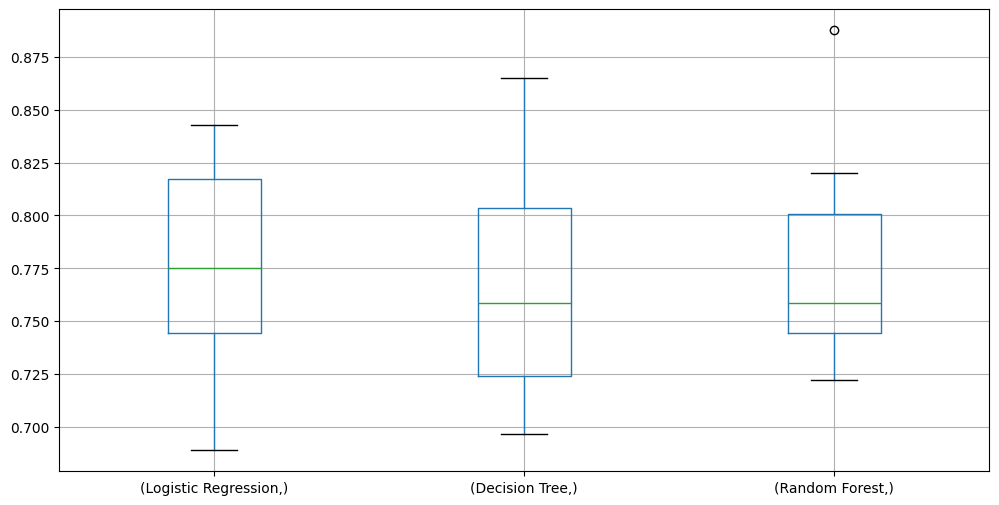

In [13]:
plt.subplots(figsize=(12,6))
box = pd.DataFrame(accuracy, index = [classifiers])
box.T.boxplot()

## Bar plot으로 CV평균 확인

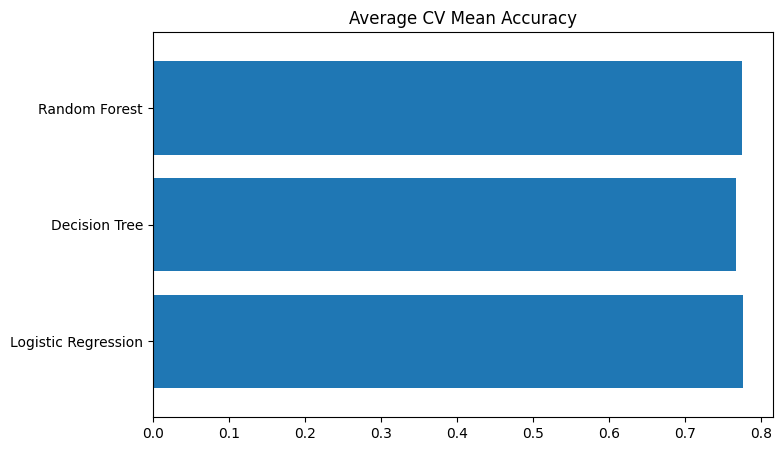

In [14]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

## 모델별 성능 지표 계산 및 출력

In [15]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'AppleGothic' 등 사용자의 OS에 맞는 한글 폰트를 지정하세요.
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지는 현상 방지

# 결과 저장을 위한 리스트
results = []

# 각 분류기에 대해 반복하며 성능 지표를 계산합니다.
for clf_name, model in zip(classifiers, models):
    y_pred = cross_val_predict(model, X, y, cv=10)  # 교차 검증을 사용하여 예측을 수행합니다.
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    results.append((clf_name, accuracy, precision, recall, f1))

# 결과를 F1-score 기준으로 정렬
results.sort(key=lambda x: x[4], reverse=True)

# 상위 n개 결과 출력
for clf_name, accuracy, precision, recall, f1 in results[:]:
    print(f"{clf_name}: 정확도={accuracy:.4f}, 정밀도={precision:.4f}, 재현율={recall:.4f}, F1-score={f1:.4f}")

Logistic Regression: 정확도=0.7811, 정밀도=0.7143, 재현율=0.7164, F1-score=0.7153
Random Forest: 정확도=0.7733, 정밀도=0.7333, 재현율=0.6433, F1-score=0.6854
Decision Tree: 정확도=0.7722, 정밀도=0.7405, 재현율=0.6257, F1-score=0.6783


## Confusion Matrix 시각화

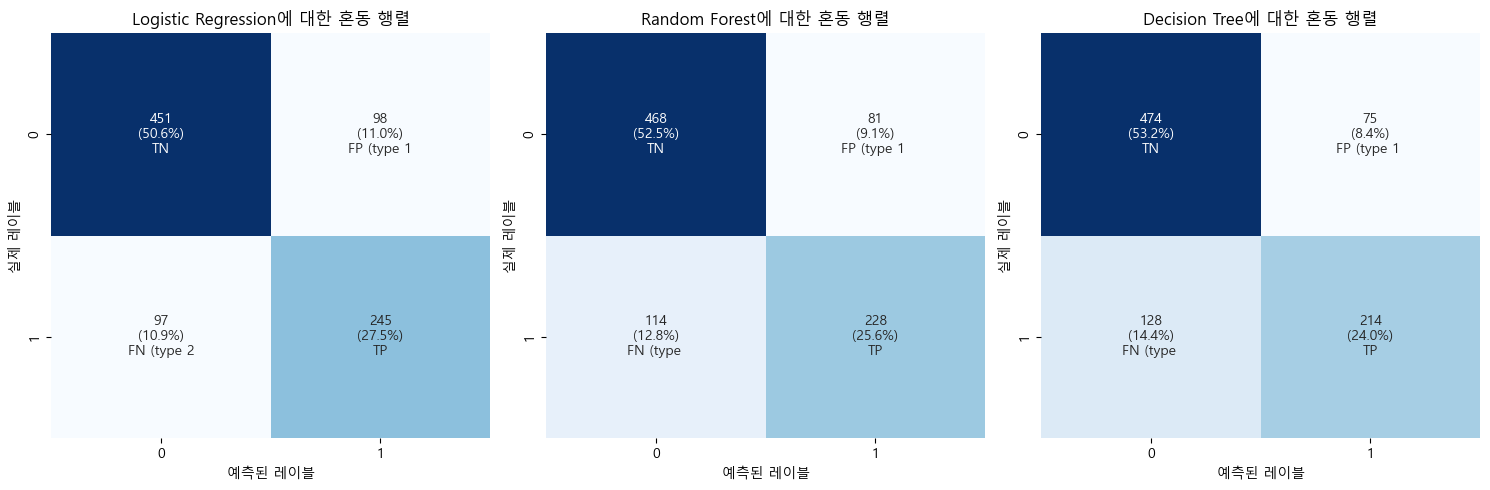

In [20]:
# 그림판 설정
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

# 각 분류기에 대해 반복하며 혼동 행렬을 플로팅합니다.
for ax, (clf_name, accuracy, precision, recall, f1) in zip(axes, results[:]):
    model = models[classifiers.index(clf_name)]
    y_pred = cross_val_predict(model, X, y, cv=10)  # 교차 검증을 사용하여 예측을 수행합니다.
    cm = confusion_matrix(y, y_pred)  # 혼동 행렬을 계산합니다.
    cm_sum = np.sum(cm)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                annot[i, j] = 'TN' if i == 0 else 'TP'
            else:
                annot[i, j] = 'FP (type 1 error)' if i == 0 else 'FN (type 2 error)'
            annot[i, j] = f'{c}\n({p:.1f}%)\n{annot[i, j]}'

    sns.heatmap(cm, ax=ax, annot=annot, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 10})  # 혼동 행렬을 시각화합니다.
    ax.set_xlabel('예측된 레이블')  # x축 레이블 설정
    ax.set_ylabel('실제 레이블')  # y축 레이블 설정
    ax.set_title(f'{clf_name}에 대한 혼동 행렬')  # 각 subplot에 분류기 이름을 제목으로 설정합니다.

plt.tight_layout()  # subplot간의 간격을 조정하여 레이아웃을 조정합니다.
plt.show()

# Hyper-Parameter Tuning

GridSearchCV를 이용하여 최적의 파라미터를 찾고, 해당 파라미터와 그 때의 정확도, 정밀도, 재현율, f1-score를 출력해봅시다.
GridSearchCV는 주어진 하이퍼파라미터 그리드에 대해 모든 조합을 시도하고, 각 조합에 대해 KFold 교차 검증을 수행하여 최적의 하이퍼파라미터를 찾습니다. 기본 설정은 KFold(n_splits=5)로 되어 있으며, 이를 변경하고 싶다면 cv 파라미터를 사용하여 설정할 수 있습니다.

## Logistic Regression

In [21]:
# Logistic Regression 모델 하이퍼파라미터 튜닝
C = [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param_grid_lr = {'C': C}
lr_gd = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, verbose=True)
lr_gd.fit(X, y)
print("Best Logistic Regression Model")
print(lr_gd.best_score_)
print(lr_gd.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression Model
0.787853869813571
LogisticRegression(C=0.05)


## Decision Tree

In [22]:
# Decision Tree 하이퍼파라미터 설정
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
dt_gd = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_dt, verbose=True, cv=10)
dt_gd.fit(X, y)

print("Best Decision Tree Model")
print(dt_gd.best_score_)
print(dt_gd.best_estimator_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best Decision Tree Model
0.7777528089887639
DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2)


## Random Forest

In [ ]:
# Random Forest 모델 하이퍼파라미터 튜닝
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],  # 트리의 개수
    'criterion': ['gini', 'entropy'],  # 분할 기준
    'max_depth': list(range(1, 21)),  # 트리의 최대 깊이
    'min_samples_split': list(range(2, 21))  # 내부 노드를 분할하는 데 필요한 최소 샘플 수
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
# RandomForestClassifier를 estimator로 사용
# 병렬 처리(n_jobs=-1)를 통해 학습 시간 단축
rf_gd = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, verbose=True, n_jobs=-1)

# 모델 피팅 (학습 데이터에 대해 최적의 하이퍼파라미터를 찾기 위해 학습)
rf_gd.fit(X, y)

print("Best Random Forest Model")
print(rf_gd.best_score_)
print(rf_gd.best_estimator_)

# Classifier 별 최적의 Hyper Parameter

In [37]:
# 하이퍼파라미터 튜닝
def tune_model(estimator, param_grid, X, y):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, verbose=True, n_jobs=-1, cv=10)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

# 각 모델의 하이퍼파라미터 그리드 설정
param_grids = {
    'Logistic Regression': {'C': [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'Random Forest': {'n_estimators': [100, 200, 300, 400, 500], 'criterion': ['gini', 'entropy'], 'max_depth': list(range(1, 21)), 'min_samples_split': list(range(2, 21))}
}

# 각 모델의 기본 설정
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# 최적 모델 저장
best_models = {}

# 각 모델에 대해 최적의 하이퍼파라미터 탐색 및 저장
for model_name in models:
    print(f"Tuning {model_name}...")
    best_model = tune_model(models[model_name], param_grids[model_name], X, y)
    best_models[model_name] = best_model

# 최종 결과 출력
print("\nBest Estimators:")
for model_name, best_model in best_models.items():
    print(f"('{model_name}', {best_model}),")


Tuning Logistic Regression...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Tuning Decision Tree...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Tuning Random Forest...
Fitting 10 folds for each of 3800 candidates, totalling 38000 fits


# Ensembling

-  n_estimators는 앙상블 학습에서 사용하는 하이퍼파라미터로, 모델이 생성하는 기본 추정기의 개수
- random_state는 모델 훈련 시의 무작위성을 제어하기 위한 시드(seed) 값을 의미

## 최적의 Hyper Parameter로 모델 정의

In [26]:
# 최적의 하이퍼파라미터로 모델을 정의
best_models = {
    'Logistic Regression': LogisticRegression(C=0.05),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_leaf=2),
    'Random Forest': RandomForestClassifier(max_depth=8, min_samples_split=10, n_estimators=200)
}

## Voting

### Logistic Regression, Decision Tree, Random Forest


The accuracy of ensembled model is: 0.7761
The F1-score of ensembled model is: 0.7752
The precision of ensembled model is: 0.7747
The recall of ensembled model is: 0.7761

The cross validated accuracy is: 0.7946
The cross validated F1-score is: 0.7906
The cross validated precision is: 0.7921
The cross validated recall is: 0.7946


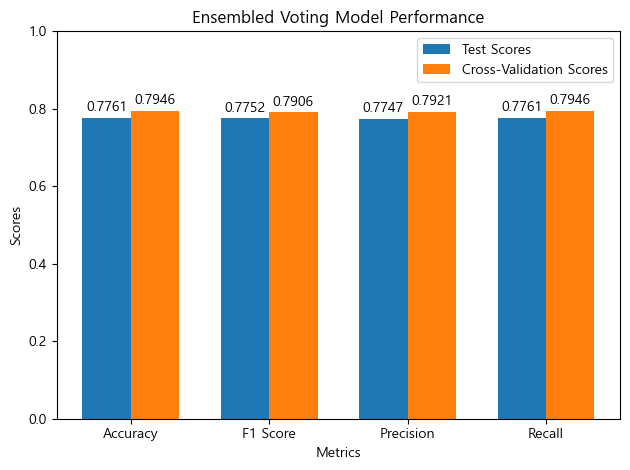

In [27]:
# 사용 가능한 모델로 대체

ensemble_lin_rbf = VotingClassifier(
    estimators=[
        ('LR', best_models['Logistic Regression']),
        ('DT', best_models['Decision Tree']),
        ('RF', best_models['Random Forest'])
    ], 
    voting='soft'
)

# 모델 학습
ensemble_lin_rbf.fit(train_X, train_Y)

# 예측
y_pred = ensemble_lin_rbf.predict(test_X)

# 모델 성능 평가
voting_accuracy = accuracy_score(test_Y, y_pred)
voting_f1 = f1_score(test_Y, y_pred, average='weighted')  # 데이터 불균형을 고려한 가중 평균
voting_precision = precision_score(test_Y, y_pred, average='weighted')
voting_recall = recall_score(test_Y, y_pred, average='weighted')

# 성능 출력
print(f'\nThe accuracy of ensembled model is: {voting_accuracy:.4f}')
print(f'The F1-score of ensembled model is: {voting_f1:.4f}')
print(f'The precision of ensembled model is: {voting_precision:.4f}')
print(f'The recall of ensembled model is: {voting_recall:.4f}')

# 교차 검증 성능 평가
cross_voting_accuracy = cross_val_score(ensemble_lin_rbf, X, y, cv=10, scoring='accuracy')
cross_voting_f1 = cross_val_score(ensemble_lin_rbf, X, y, cv=10, scoring='f1_weighted')
cross_voting_precision = cross_val_score(ensemble_lin_rbf, X, y, cv=10, scoring='precision_weighted')
cross_voting_recall = cross_val_score(ensemble_lin_rbf, X, y, cv=10, scoring='recall_weighted')

# 교차 검증 성능 출력
print(f'\nThe cross validated accuracy is: {cross_voting_accuracy.mean():.4f}')
print(f'The cross validated F1-score is: {cross_voting_f1.mean():.4f}')
print(f'The cross validated precision is: {cross_voting_precision.mean():.4f}')
print(f'The cross validated recall is: {cross_voting_recall.mean():.4f}')

# 모델 성능 지표
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
voting_test_scores = [voting_accuracy, voting_f1, voting_precision, voting_recall]
voting_cv_scores = [cross_voting_accuracy.mean(), cross_voting_f1.mean(), cross_voting_precision.mean(), cross_voting_recall.mean()]

def plot_voting_performance(metrics, test_scores, cv_scores, title='Voting Model Performance'):
    fig, ax = plt.subplots()
    bar_width = 0.35
    index = np.arange(len(metrics))

    bar1 = ax.bar(index, test_scores, bar_width, label='Test Scores')
    bar2 = ax.bar(index + bar_width, cv_scores, bar_width, label='Cross-Validation Scores')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.legend()

    for i, v in enumerate(test_scores):
        ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')
    for i, v in enumerate(cv_scores):
        ax.text(i + bar_width, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_voting_performance(metrics, voting_test_scores, voting_cv_scores, title='Ensembled Voting Model Performance')

## Bagging

### Logistic Regression
### Decision Tree
- BaggingClassifier는 일반적으로 Random Forest와 함께 사용되지 않습니다. 왜냐하면 RandomForestClassifier 자체가 이미 의사 결정 나무들의 앙상블을 사용하기 때문입니다.

In [28]:
# 최적의 하이퍼파라미터로 BaggingClassifier를 정의
bagging_models = {
    'Logistic Regression': BaggingClassifier(estimator=best_models['Logistic Regression'], n_estimators=100, random_state=2020),
    'Decision Tree': BaggingClassifier(estimator=best_models['Decision Tree'], n_estimators=100, random_state=2020)
}

# 각 Bagging 모델에 대한 성능 평가 결과 저장
results = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'CV Accuracy': [],
    'CV F1 Score': [],
    'CV Precision': [],
    'CV Recall': []
}

# 각 Bagging 모델에 대한 성능 평가
for name, model in bagging_models.items():
    model.fit(train_X, train_Y)
    y_pred = model.predict(test_X)
    
    accuracy = accuracy_score(test_Y, y_pred)
    f1 = f1_score(test_Y, y_pred, average='weighted')
    precision = precision_score(test_Y, y_pred, average='weighted')
    recall = recall_score(test_Y, y_pred, average='weighted')
    
    print(f'The accuracy of {name} bagging model is: {accuracy:.4f}')
    print(f'The F1-score of {name} bagging model is: {f1:.4f}')
    print(f'The precision of {name} bagging model is: {precision:.4f}')
    print(f'The recall of {name} bagging model is: {recall:.4f}')
    
    cross_accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    cross_f1 = cross_val_score(model, X, y, cv=10, scoring='f1_weighted')
    cross_precision = cross_val_score(model, X, y, cv=10, scoring='precision_weighted')
    cross_recall = cross_val_score(model, X, y, cv=10, scoring='recall_weighted')
    
    print(f'The cross validated accuracy for {name} is: {cross_accuracy.mean():.4f}')
    print(f'The cross validated F1-score for {name} is: {cross_f1.mean():.4f}')
    print(f'The cross validated precision for {name} is: {cross_precision.mean():.4f}')
    print(f'The cross validated recall for {name} is: {cross_recall.mean():.4f}')
    print("\n")

    # 결과 저장
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['CV Accuracy'].append(cross_accuracy.mean())
    results['CV F1 Score'].append(cross_f1.mean())
    results['CV Precision'].append(cross_precision.mean())
    results['CV Recall'].append(cross_recall.mean())


The accuracy of Logistic Regression bagging model is: 0.7910
The F1-score of Logistic Regression bagging model is: 0.7893
The precision of Logistic Regression bagging model is: 0.7890
The recall of Logistic Regression bagging model is: 0.7910
The cross validated accuracy for Logistic Regression is: 0.7878
The cross validated F1-score for Logistic Regression is: 0.7854
The cross validated precision for Logistic Regression is: 0.7866
The cross validated recall for Logistic Regression is: 0.7878


The accuracy of Decision Tree bagging model is: 0.7724
The F1-score of Decision Tree bagging model is: 0.7707
The precision of Decision Tree bagging model is: 0.7702
The recall of Decision Tree bagging model is: 0.7724
The cross validated accuracy for Decision Tree is: 0.7811
The cross validated F1-score for Decision Tree is: 0.7779
The cross validated precision for Decision Tree is: 0.7802
The cross validated recall for Decision Tree is: 0.7811




## Boosting with Hyper Parameter Tuning

#### Adaboost - DecisionTree
Boosting의 estimator는 DecisionTreeClassifier 이 기본 학습기이고, 성능이 좋았던 모델에 대해 Boosting 기법을 추가로 적용해 볼 수도 있습니다. 

In [29]:
# AdaBoost Classifier
ada_boost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7), n_estimators=10, random_state=2020)
ada_boost.fit(train_X, train_Y)
y_pred = ada_boost.predict(test_X)

accuracy = accuracy_score(test_Y, y_pred)
f1 = f1_score(test_Y, y_pred, average='weighted')
precision = precision_score(test_Y, y_pred, average='weighted')
recall = recall_score(test_Y, y_pred, average='weighted')

print('The accuracy of AdaBoost model is : ', accuracy)
print('The F1-score of AdaBoost model is : ', f1)
print('The precision of AdaBoost model is : ', precision)
print('The recall of AdaBoost model is : ', recall)

cross_accuracy = cross_val_score(ada_boost, X, y, cv=10, scoring='accuracy')
cross_f1 = cross_val_score(ada_boost, X, y, cv=10, scoring='f1_weighted')
cross_precision = cross_val_score(ada_boost, X, y, cv=10, scoring='precision_weighted')
cross_recall = cross_val_score(ada_boost, X, y, cv=10, scoring='recall_weighted')

print(f'The cross validated accuracy is: {cross_accuracy.mean():.4f}')
print(f'The cross validated F1-score is: {cross_f1.mean():.4f}')
print(f'The cross validated precision is: {cross_precision.mean():.4f}')
print(f'The cross validated recall is: {cross_recall.mean():.4f}')

The accuracy of AdaBoost model is :  0.7873134328358209
The F1-score of AdaBoost model is :  0.7841809171938162
The precision of AdaBoost model is :  0.7849940373041161
The recall of AdaBoost model is :  0.7873134328358209
The cross validated accuracy is: 0.7811
The cross validated F1-score is: 0.7776
The cross validated precision is: 0.7801
The cross validated recall is: 0.7811


#### AdaBoost - Logistic Regression

In [30]:
# AdaBoost Classifier with Logistic Regression
ada_boost_lr = AdaBoostClassifier(estimator=LogisticRegression(), n_estimators=10, random_state=2020)
ada_boost_lr.fit(train_X, train_Y)
y_pred = ada_boost_lr.predict(test_X)

accuracy = accuracy_score(test_Y, y_pred)
f1 = f1_score(test_Y, y_pred, average='weighted')
precision = precision_score(test_Y, y_pred, average='weighted')
recall = recall_score(test_Y, y_pred, average='weighted')

print('The accuracy of AdaBoost model is : ', accuracy)
print('The F1-score of AdaBoost model is : ', f1)
print('The precision of AdaBoost model is : ', precision)
print('The recall of AdaBoost model is : ', recall)

cross_accuracy = cross_val_score(ada_boost, X, y, cv=10, scoring='accuracy')
cross_f1 = cross_val_score(ada_boost, X, y, cv=10, scoring='f1_weighted')
cross_precision = cross_val_score(ada_boost, X, y, cv=10, scoring='precision_weighted')
cross_recall = cross_val_score(ada_boost, X, y, cv=10, scoring='recall_weighted')

print(f'The cross validated accuracy is: {cross_accuracy.mean():.4f}')
print(f'The cross validated F1-score is: {cross_f1.mean():.4f}')
print(f'The cross validated precision is: {cross_precision.mean():.4f}')
print(f'The cross validated recall is: {cross_recall.mean():.4f}')

The accuracy of AdaBoost model is :  0.7910447761194029
The F1-score of AdaBoost model is :  0.7892963013514104
The precision of AdaBoost model is :  0.7890250602781649
The recall of AdaBoost model is :  0.7910447761194029
The cross validated accuracy is: 0.7811
The cross validated F1-score is: 0.7776
The cross validated precision is: 0.7801
The cross validated recall is: 0.7811


### Gradient Boosting

In [31]:
# Gradient Boosting Classifier
gradient_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.02, max_depth=3, random_state=2020)
gradient_boost.fit(train_X, train_Y)
y_pred = gradient_boost.predict(test_X)

accuracy = accuracy_score(test_Y, y_pred)
f1 = f1_score(test_Y, y_pred, average='weighted')
precision = precision_score(test_Y, y_pred, average='weighted')
recall = recall_score(test_Y, y_pred, average='weighted')

print('The accuracy of Gradient Boosting model is : ', accuracy)
print('The F1-score of Gradient Boosting model is : ', f1)
print('The precision of Gradient Boosting model is : ', precision)
print('The recall of Gradient Boosting model is : ', recall)

cross_accuracy = cross_val_score(gradient_boost, X, y, cv=10, scoring='accuracy')
cross_f1 = cross_val_score(gradient_boost, X, y, cv=10, scoring='f1_weighted')
cross_precision = cross_val_score(gradient_boost, X, y, cv=10, scoring='precision_weighted')
cross_recall = cross_val_score(gradient_boost, X, y, cv=10, scoring='recall_weighted')

print(f'The cross validated accuracy is: {cross_accuracy.mean():.4f}')
print(f'The cross validated F1-score is: {cross_f1.mean():.4f}')
print(f'The cross validated precision is: {cross_precision.mean():.4f}')
print(f'The cross validated recall is: {cross_recall.mean():.4f}')

The accuracy of Gradient Boosting model is :  0.7910447761194029
The F1-score of Gradient Boosting model is :  0.7910447761194029
The precision of Gradient Boosting model is :  0.7910447761194029
The recall of Gradient Boosting model is :  0.7910447761194029
The cross validated accuracy is: 0.7946
The cross validated F1-score is: 0.7938
The cross validated precision is: 0.7973
The cross validated recall is: 0.7946


### XGBoost

In [32]:
# XGBoost Classifier
xg_boost = xgb.XGBClassifier(n_estimators=100, learning_rate=0.02, max_depth=3, random_state=2020)
xg_boost.fit(train_X, train_Y)
y_pred = xg_boost.predict(test_X)

accuracy = accuracy_score(test_Y, y_pred)
f1 = f1_score(test_Y, y_pred, average='weighted')
precision = precision_score(test_Y, y_pred, average='weighted')
recall = recall_score(test_Y, y_pred, average='weighted')

print('The accuracy of XGBoost model is : ', accuracy)
print('The F1-score of XGBoost model is : ', f1)
print('The precision of XGBoost model is : ', precision)
print('The recall of XGBoost model is : ', recall)

cross_accuracy = cross_val_score(xg_boost, X, y, cv=10, scoring='accuracy')
cross_f1 = cross_val_score(xg_boost, X, y, cv=10, scoring='f1_weighted')
cross_precision = cross_val_score(xg_boost, X, y, cv=10, scoring='precision_weighted')
cross_recall = cross_val_score(xg_boost, X, y, cv=10, scoring='recall_weighted')

print(f'The cross validated accuracy is: {cross_accuracy.mean():.4f}')
print(f'The cross validated F1-score is: {cross_f1.mean():.4f}')
print(f'The cross validated precision is: {cross_precision.mean():.4f}')
print(f'The cross validated recall is: {cross_recall.mean():.4f}')

The accuracy of XGBoost model is :  0.7798507462686567
The F1-score of XGBoost model is :  0.7792156909501223
The precision of XGBoost model is :  0.7787819829424306
The recall of XGBoost model is :  0.7798507462686567
The cross validated accuracy is: 0.7868
The cross validated F1-score is: 0.7853
The cross validated precision is: 0.7875
The cross validated recall is: 0.7868


### LightGBM

In [33]:
# LightGBM Classifier
lgbm = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=2020,
    min_child_samples=5,  # min_data_in_leaf 대체 (기본값: 20에서 10으로 변경)
    min_split_gain=0.0,  # min_gain_to_split 대체 (기본값: 0.01에서 0으로 변경)
    max_depth=7,  # 트리의 최대 깊이 (기본값: 제한 없음)
    num_leaves=31,  # 리프 노드의 최대 수 (기본값: 31에서 50으로 변경)
    learning_rate=0.02,  # 학습 속도 (기본값: 0.1에서 0.01로 변경)
    force_col_wise=True  # 오버헤드 제거
)
lgbm.fit(train_X, train_Y)
y_pred = lgbm.predict(test_X)

# 성능 평가
accuracy = accuracy_score(test_Y, y_pred)
f1 = f1_score(test_Y, y_pred, average='weighted')
precision = precision_score(test_Y, y_pred, average='weighted')
recall = recall_score(test_Y, y_pred, average='weighted')

print('The accuracy of LightGBM model is : ', accuracy)
print('The F1-score of LightGBM model is : ', f1)
print('The precision of LightGBM model is : ', precision)
print('The recall of LightGBM model is : ', recall)

# 교차 검증 성능 평가
cross_accuracy = cross_val_score(lgbm, X, y, cv=10, scoring='accuracy').mean()
cross_f1 = cross_val_score(lgbm, X, y, cv=10, scoring='f1_weighted').mean()
cross_precision = cross_val_score(lgbm, X, y, cv=10, scoring='precision_weighted').mean()
cross_recall = cross_val_score(lgbm, X, y, cv=10, scoring='recall_weighted').mean()

print(f'The cross validated accuracy is: {cross_accuracy:.4f}')
print(f'The cross validated F1-score is: {cross_f1:.4f}')
print(f'The cross validated precision is: {cross_precision:.4f}')
print(f'The cross validated recall is: {cross_recall:.4f}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### CatBoost

In [34]:
# CatBoost Classifier
catboost = CatBoostClassifier(
    iterations=500,           # 부스팅 반복 횟수
    learning_rate=0.005,       # 학습률
    depth=6,                  # 트리의 최대 깊이
    l2_leaf_reg=3,            # L2 정규화 계수
    border_count=32,          # 숫자형 특징의 최적 구간 수
    bagging_temperature=1,    # 부트스트랩 샘플링 온도
    random_strength=1,        # 분할 시 랜덤 노이즈 강도
    one_hot_max_size=50,       # 원-핫 인코딩할 최대 카테고리 개수
    random_seed=2020,         # 랜덤 시드
    verbose=0                 # 출력 로그 레벨
)

catboost.fit(train_X, train_Y)
y_pred = catboost.predict(test_X)

# 성능 평가
accuracy = accuracy_score(test_Y, y_pred)
f1 = f1_score(test_Y, y_pred, average='weighted')
precision = precision_score(test_Y, y_pred, average='weighted')
recall = recall_score(test_Y, y_pred, average='weighted')

print('The accuracy of CatBoost model is : ', accuracy)
print('The F1-score of CatBoost model is : ', f1)
print('The precision of CatBoost model is : ', precision)
print('The recall of CatBoost model is : ', recall)

# 교차 검증 성능 평가
cross_accuracy = cross_val_score(catboost, X, y, cv=10, scoring='accuracy').mean()
cross_f1 = cross_val_score(catboost, X, y, cv=10, scoring='f1_weighted').mean()
cross_precision = cross_val_score(catboost, X, y, cv=10, scoring='precision_weighted').mean()
cross_recall = cross_val_score(catboost, X, y, cv=10, scoring='recall_weighted').mean()

# 교차 검증 성능 평가 결과 출력
print('\nCross-Validation Results:')
print('The cross-validated accuracy is : ', cross_accuracy)
print('The cross-validated F1-score is : ', cross_f1)
print('The cross-validated precision is : ', cross_precision)
print('The cross-validated recall is : ', cross_recall)

The accuracy of CatBoost model is :  0.7798507462686567
The F1-score of CatBoost model is :  0.7787554763495953
The precision of CatBoost model is :  0.77822248302306
The recall of CatBoost model is :  0.7798507462686567

Cross-Validation Results:
The cross-validated accuracy is :  0.7968664169787766
The cross-validated F1-score is :  0.7955661100985657
The cross-validated precision is :  0.797775896735035
The cross-validated recall is :  0.7968664169787766


## 최종모델의 Confusion Matrix

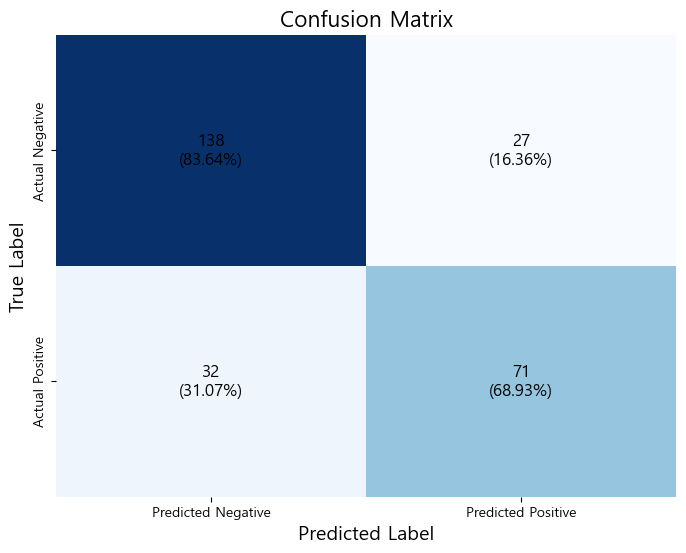

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 최적의 모델을 다시 훈련
catboost.fit(train_X, train_Y)
y_pred = catboost.predict(test_X)

# Confusion Matrix 생성
conf_matrix = confusion_matrix(test_Y, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

# 각 셀에 레이블 추가
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{conf_matrix[i, j]}\n({conf_matrix_norm[i, j]:.2%})', ha='center', va='center', color='black', fontsize=12)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


## 결과 해석 및 결론

### CatBoost 모델의 타이타닉 데이터셋 성능 고찰

CatBoost가 타이타닉 데이터셋에서 가장 좋은 성능을 보인 이유를 다른 모델들과 비교하여 간단하게 정리해 보겠습니다.

#### CatBoost의 특징
1. **범주형 데이터 처리**: CatBoost는 범주형 데이터를 효율적으로 처리합니다. 타이타닉 데이터셋에는 성별, 승객 클래스, 승선 항구 등 여러 범주형 데이터가 포함되어 있어 CatBoost가 특히 유리했습니다.
2. **과적합 방지**: 과적합을 방지하는 데 강점이 있어, 작은 데이터셋에서도 일반화 성능이 뛰어납니다.
3. **자동 파라미터 조정**: 기본 설정만으로도 좋은 성능을 낼 수 있습니다.

#### 다른 모델과의 비교

1. **로지스틱 회귀 (Logistic Regression)**
   - **특징**: 선형 모델로, 비선형 관계를 잘 잡아내지 못함.

2. **결정 트리 (Decision Tree)**
   - **특징**: 단순한 트리 구조, 과적합 발생 가능성 높음.

3. **랜덤 포레스트 (Random Forest)**
   - **특징**: 여러 결정 트리 앙상블, 범주형 데이터 처리에서 CatBoost보다 효율성 떨어짐.

4. **Gradient Boosting**
   - **특징**: 여러 약한 학습기 순차적 학습, CatBoost가 범주형 데이터 처리에서 더 효율적.

#### 고찰
타이타닉 데이터셋은 다양한 연속형 및 범주형 변수를 포함하는 이진 분류 문제입니다. CatBoost는 범주형 데이터 처리, 과적합 방지, 자동 파라미터 조정에서 강점을 가지고 있어 타이타닉 데이터셋에서 최고의 성능을 보였습니다. 이러한 특성 덕분에 CatBoost는 다른 모델들보다 우수한 성능을 발휘했습니다.